## Bitcoin/Cryptocurrency

Cryptocurrencies are digital currencies based on blockchain technology. Their sizes are often measured based on their market capitalization volume, which is calculated as Market Cap = Current Price x Circulating Supply). The three cryptos of interest are among the top 5 in terms of market capitalization - notably, Bitcoin has a market capitalization of about 1.033 Trillion USD, as of March 28, 2021.

***
Buying bitcoin is different than purchasing a stock or bond because there is no financial reports to review or crypto ETF to spread out investment risks (at least, not yet). And unlike fiat currencies, bitcoin is not issued by a central bank or backed by any government, therefore the typical measures such as monetary policy and GDP growth that would impact the value of fiat currencies are not applicable. 

However, it is **not impossible** to predict bitcoin prices. My hypothesis is that the following factors influence the Bitcoin pricing trend:

	1. Supply of bitcoin and the market demand for it
	2. The cost of bitcoin through the mining/creation process
	3. The rewards issued to the miners for verifying transactions to the blockchain
	4. The number and market size of competing cryptocurrencies
	5. The exchanges it trades on
	6. Regulations governing its trade
	7. Its internal security and governance
	8. User adoption
***

I thereby gathered historical, 2020, Bitcoin (BTC) and Ethereum (ETH) prices from Coindesk.com, and three potential price drivers (total number of Bitcoin in the market, total number of confirmed payments, and total hash rate) from Blockchain.com. 

# 1. Data Collection, Wrangling and Exploration

In [34]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from datetime import datetime
import time
import matplotlib.ticker as mticker
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('bmh')

%matplotlib inline 

BTCrawdata = requests.get('https://production.api.coindesk.com/v2/price/values/BTC?start_date=2020-01-01T00:00&end_date=2021-01-04T12:00&ohlc=false').json()
ETHrawdata = requests.get('https://production.api.coindesk.com/v2/price/values/ETH?start_date=2020-01-01T00:00&end_date=2021-01-04T12:00&ohlc=false').json()

## 1.1 Data Wrangling - Crypto Prices

Now we want to take a look at the first ten actual date time and pricing items in the dictionary BTCrawdata['data'] and ETHrawdata['data'] to get an idea of the format -

In [35]:
list(BTCrawdata['data'].items())[:5]

[('iso', 'BTC'),
 ('name', 'Bitcoin'),
 ('slug', 'bitcoin'),
 ('ingestionStart', '2013-10-01'),
 ('interval', '1-day')]

In [36]:
list(ETHrawdata['data'].items())[:5]

[('iso', 'ETH'),
 ('name', 'Ethereum'),
 ('slug', 'ethereum'),
 ('ingestionStart', '2015-08-09'),
 ('interval', '1-day')]

In [37]:
list(BTCrawdata['data'].items())[5][1][:5]

[[1577923199000, 7174.7440119511],
 [1578009599000, 6955.4875796712],
 [1578095999000, 7291.2195053189],
 [1578182399000, 7337.6366701377],
 [1578268799000, 7347.4332644392]]

We now know that the raw BTC data is structured as the daily closing price - going back to as far as Oct 1st, 2013. This is helpful in case we need to expand the study period later. ETH data is only available after Aug 9th, 2015.

## 1.2 Data Wrangling - Bitcoin Pricing Drivers Data

Next, I want to introduce the potential drivers of bitcoin values, which includes 3 items: BTC in Circulation per day, the Total Number of Comfirmed Payments per day, and Hash Rate per day. 

BTC in circulation is important because it represents the total bitcoin supply on the network - it is the number of bitcoins that have already been mined. Given the nature of limited supply (21 Million), ceteris paribus, bitcoin's value should be conversely correlated to the amount of un-mined supply. Or conversely, the price should be positively correlated to the supply. 

Secondly, total number of confirmed BTC payment is defined as the number of recipients receiving funds in a transaction. According to Blockchain.com, "the number of daily confirmed payments highlights the value of the Bitcoin network as a way to securely transfer funds without a third part." Because a single BTC transaction can include multiple payments (to multiple recipients), the number of payments is a good indicator of the general network activity - which I would use as a proxy for market demand.

Lastly, Hash rate is a crucial security metrics that reflects that estimated number of tera hashes per second (trillions of hashes per second) the Bitcoin network is performing. In other words, it measures the combined computer power needed to mine and process transactions on a Proof-of-Work blockchain. Without a central authority to secure and control the supply, bitcoin's value is directly attributed to its security and trustworthiness. As more bitcoins are mined, hash rate increases, and it becomes harder to "break" the blockchain. Thus the network is secured against fraud.

In [38]:
BTCinCirculationRaw = requests.get('https://api.blockchain.info/charts/total-bitcoins?start=2020-01-01T00:00:00').json()
BTCpaymentsRaw = pd.read_json('Crypto/n-payments.json')
BTCHashRateRaw = requests.get('https://api.blockchain.info/charts/hash-rate?start=2020-01-01T00:00:00').json()

In [39]:
BTCinCirculationRaw['values'][:5]

[{'x': 1577836985, 'y': 18133650.0},
 {'x': 1577860942, 'y': 18134087.5},
 {'x': 1577878570, 'y': 18134537.5},
 {'x': 1577893144, 'y': 18134975.0},
 {'x': 1577907501, 'y': 18135412.5}]

In [40]:
BTCpaymentsRaw['values'][:5]

0    {'x': 1522368000, 'y': 386161}
1    {'x': 1522454400, 'y': 270378}
2    {'x': 1522540800, 'y': 263981}
3    {'x': 1522627200, 'y': 315045}
4    {'x': 1522713600, 'y': 360686}
Name: values, dtype: object

In [41]:
BTCHashRateRaw['values'][-5:]

[{'x': 1609027200, 'y': 137358668.73416725},
 {'x': 1609113600, 'y': 147938033.9968089},
 {'x': 1609200000, 'y': 140537799.38571388},
 {'x': 1609286400, 'y': 159029615.0943604},
 {'x': 1609372800, 'y': 153482070.38176647}]

In [42]:
1577923200 - 1577836800

86400

I was able to get the circulating BTC number and the hash rate through API, but I had to download the number of payment as json - so it has a different format and a different starting date. I am going to use merge the three numbers together using the date/time value ("x").

Also, notice that BTC in circulation's datetime are different than those of payments and hash rate, which have intervals of 86400 (representing the number of seconds in a day). BTC in circirlation's data is reported at an irregular interval. Upon a closer look, the total number of mined bitcoins are reported in intervals of 218.75, 225, 437.5 and 450. Based on the notes on Blockchain.com, Bitcoin reward is decreasing as more bitcoins are mined - and the reward is divided by 2 every 210,000 blocks, or approximately four years. That seems to have explained why the reporting interval reduced from 437.5 and 450 to 218.75 and 225, on May 12th, 2020 - because the speed of the mining reward (aka bitcoin creation) is suddenly reduced by half on that day. 

In [43]:
BTCcirc = []
for i in range(len(BTCinCirculationRaw['values'])):
    for x in BTCinCirculationRaw['values'][i].values():
        BTCcirc.append(x)

In [44]:
BTCHR = []
for i in range(len(BTCHashRateRaw['values'])):
    for x in BTCHashRateRaw['values'][i].values():
        BTCHR.append(x)

In [45]:
BTCHR[:10]

[1577836800,
 112718458.532564,
 1577923200,
 96717718.3123778,
 1578009600,
 115924073.721928,
 1578096000,
 115238132.457301,
 1578182400,
 111808426.134167]

In [46]:
BTCpay = []
for i in range(len(BTCpaymentsRaw['values'])):
    for x in BTCpaymentsRaw['values'][i].values():
        BTCpay.append(x)

In [47]:
List1 = []
List2 = []
for i in range(len(BTCcirc)):
    if (i+2) % 2 == 1:
        List2.append(BTCcirc[i])
    else:
        List1.append(BTCcirc[i])

In [48]:
List3 = []
List4 = []
for i in range(len(BTCHR)):
    if (i+2) % 2 == 1:
        List4.append(BTCHR[i])
    else:
        List3.append(BTCHR[i])

In [49]:
List5 = []
List6 = []
for i in range(len(BTCpay)):
    if (i+2) % 2 == 1:
        List6.append(BTCpay[i])
    else:
        List5.append(BTCpay[i])

In order to join the drivers together along with the bitcoin pricing data, I need the BTC in circulation info reportedn in a daily format. 

In [50]:
circrawdatetime = pd.DataFrame(list(zip(List1,List2)), columns =['Date Time', 'Total Number Bitcoin'])

In [51]:
circrawdatetime.head()

,Date Time,Total Number Bitcoin
0,1577836985,18133650.0
1,1577860942,18134087.5
2,1577878570,18134537.5
3,1577893144,18134975.0
4,1577907501,18135412.5


In [52]:
List1new= []
for i in range(len(List1)):
    x = datetime.utcfromtimestamp(List1[i]).strftime('%Y/%m/%d')
    List1new.append(x)

In [53]:
circrawdatetime = pd.DataFrame(list(zip(List1new,List2)), columns =['Date Time', 'Total Number Bitcoin'])

In [54]:
circrawdatetime.head()

,Date Time,Total Number Bitcoin
0,2020/01/01,18133650.0
1,2020/01/01,18134087.5
2,2020/01/01,18134537.5
3,2020/01/01,18134975.0
4,2020/01/01,18135412.5


In [55]:
circrawdatetime = circrawdatetime.drop_duplicates(subset=['Date Time'], keep='last')

In [56]:
List3new= []
for i in range(len(List3)):
    x = datetime.utcfromtimestamp(List3[i]).strftime('%Y/%m/%d')
    List3new.append(x)

In [57]:
List5new= []
for i in range(len(List5)):
    x = datetime.utcfromtimestamp(List5[i]).strftime('%Y/%m/%d')
    List5new.append(x)

In [58]:
driverdf0 = pd.DataFrame(list(zip(List5new,List6)), columns =['Date Time', 'Total Number of Confirmed Payments'])
driverdfhr = pd.DataFrame(list(zip(List3new,List4)), columns =['Date Time', 'Total Hash Rate (TH/s)'])
driverdf0 = driverdf0[driverdf0['Date Time'] >= '2020/01/01'].sort_values(by='Date Time')
merged1 = pd.merge(left=circrawdatetime, right=driverdf0, left_on='Date Time', right_on='Date Time')
merged2 = pd.merge(left=merged1, right=driverdfhr, left_on='Date Time', right_on='Date Time')
merged2

,Date Time,Total Number Bitcoin,Total Number of Confirmed Payments,Total Hash Rate (TH/s)
0,2020/01/01,18135412.50,396386,1.127185e+08
1,2020/01/02,18137162.50,483567,9.671772e+07
2,2020/01/03,18139375.00,503607,1.159241e+08
3,2020/01/04,18141575.00,462587,1.152381e+08
4,2020/01/05,18143775.00,471825,1.118084e+08
...,...,...,...,...
360,2020/12/26,18581768.75,584918,1.271496e+08
361,2020/12/27,18582862.50,643292,1.373587e+08
362,2020/12/28,18583737.50,670402,1.479380e+08
363,2020/12/29,18584837.50,724108,1.405378e+08


## 1.3 Data Exploration - Bitcoin Pricing Drivers

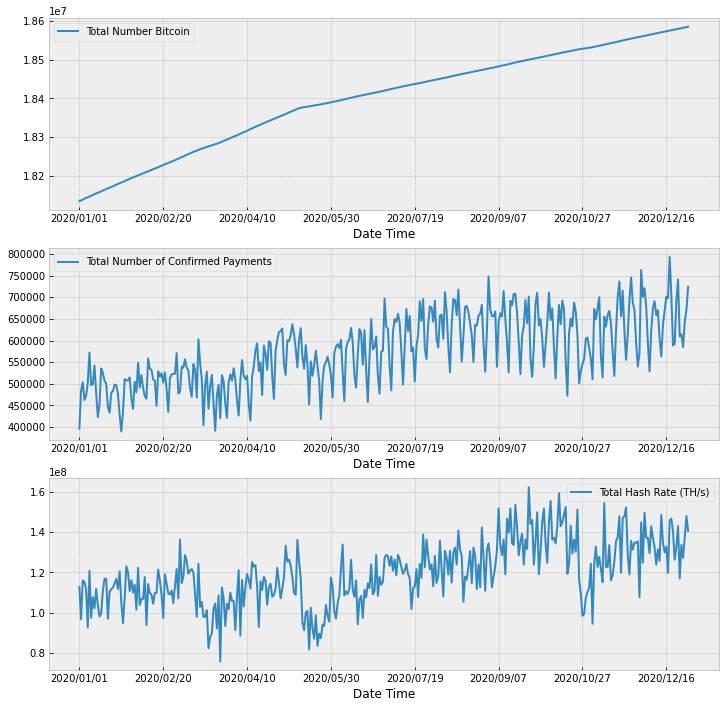

In [59]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
merged2.iloc[:364].plot(x='Date Time', y='Total Number Bitcoin', ax=axs[0])
merged2.iloc[:364].plot(x='Date Time', y='Total Number of Confirmed Payments', ax=axs[1])
merged2.iloc[:364].plot(x='Date Time', y='Total Hash Rate (TH/s)', ax=axs[2])
plt.show()

There is a lot of volatility in the "Total Number of confirmed Payments" and "Total Hash Rate" - I would like to reduce the noise by looking at the aggregated monthly values.

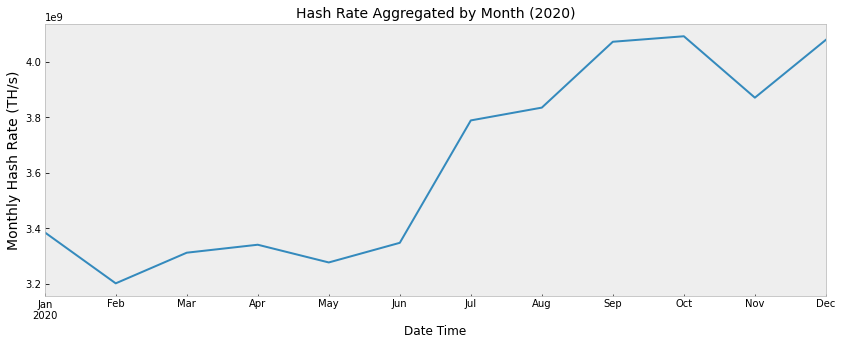

In [60]:
#Plotting average monthly Total Hash Rate (TH/s) profile observed over the entire period 
merged2copy = merged2.copy()
merged2copy['Date Time'] = pd.to_datetime(merged2['Date Time'])
merged2b = merged2copy.set_index('Date Time')
merged2d = merged2b.resample('M')['Total Hash Rate (TH/s)'].sum()
merged2b.resample('M')['Total Hash Rate (TH/s)'].sum().plot(figsize = (14,5))
_ = plt.ylabel('Monthly Hash Rate (TH/s)',fontsize=14)
_ = plt.title('Hash Rate Aggregated by Month (2020)',fontsize=14)
plt.grid(b=None, which='major', axis='both')

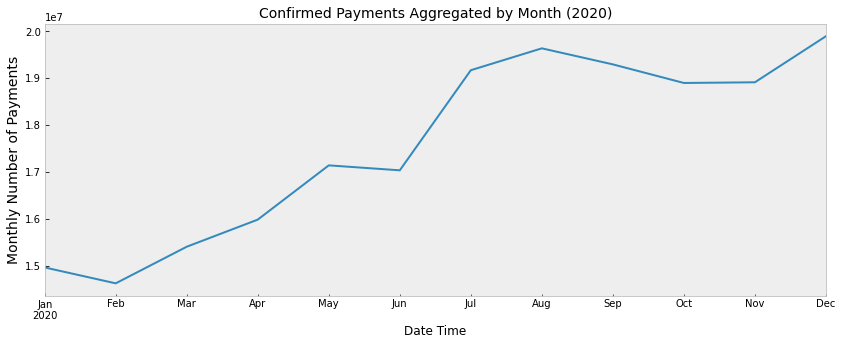

In [61]:
merged2c = merged2b.resample('M')['Total Number of Confirmed Payments'].sum()
merged2b.resample('M')['Total Number of Confirmed Payments'].sum().plot(figsize = (14,5))
_ = plt.ylabel('Monthly Number of Payments',fontsize=14)
_ = plt.title('Confirmed Payments Aggregated by Month (2020)',fontsize=14)
plt.grid(b=None, which='major', axis='both')

There is a clear upward trend in both the number of payments and hash rate - this makes sense. In 2020, crypos like Bitcoin have gained tremedous amount of interest among both retail investors and insititutional invsetors - it is logical that the number of payments, an indictive measure of market demand, had gone up. On the other hand, Bitcoin was desgined to be more difficult to mine as the supply increases, so the hash rate should have gone up when the total number of Bitcoin in circulation did. 

## 1.4 Data Exploration - Bitcoin Prices

Now that we have the 3 potential price drivers organized in a single dataframe, I am going to organize the pricing data in the same fashion.

In [62]:
BTCdf = pd.DataFrame(BTCrawdata['data']['entries'], columns=['Time','BTC Closing Price (USD)'])
BTCdf.shape

(370, 2)

In [63]:
BTCdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Time                     370 non-null    int64  
 1   BTC Closing Price (USD)  370 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.9 KB


In [64]:
df = pd.concat([BTCdf.shift(1), BTCdf], axis=1)
df.columns = ['Time_red','BTC Opening Price (USD)','Time','BTC Closing Price (USD)']
df = df.drop(columns='Time_red',index=0)
BTCdf = df.reindex(columns=['Time','BTC Opening Price (USD)','BTC Closing Price (USD)'])

In [65]:
BTCdf

,Time,BTC Opening Price (USD),BTC Closing Price (USD)
1,1578009599000,7174.744012,6955.487580
2,1578095999000,6955.487580,7291.219505
3,1578182399000,7291.219505,7337.636670
4,1578268799000,7337.636670,7347.433264
5,1578355199000,7347.433264,7713.860754
...,...,...,...
365,1609459199000,28768.836208,29111.521567
366,1609545599000,29111.521567,29333.605121
367,1609631999000,29333.605121,32154.167363
368,1609718399000,32154.167363,33002.536427


In [66]:
BTCdf.describe()

,Time,BTC Opening Price (USD),BTC Closing Price (USD)
count,3.690000e+02,369.000000,369.000000
mean,1.593907e+12,11290.028787,11355.765558
std,9.215887e+09,4654.760341,4766.428506
min,1.578010e+12,4944.702336,4944.702336
25%,1.585958e+12,8904.713817,8905.781605
50%,1.593907e+12,9719.480854,9723.680150
75%,1.601856e+12,11674.624354,11678.373255
max,1.609805e+12,33002.536427,33002.536427


In [67]:
ETHdf = pd.DataFrame(ETHrawdata['data']['entries'], columns=['Time','ETH Closing Price (USD)'])
ethopen_prices = [ETHdf.iloc[0,1]] + ETHdf.iloc[0:369,1].tolist()
ETHdf['ETH Opening Price (USD)'] = ethopen_prices
ETHdf['ETH Opening Price (USD)'] = round(ETHdf['ETH Opening Price (USD)'], 2)
ETHdf['ETH Closing Price (USD)'] = round(ETHdf['ETH Closing Price (USD)'], 2)
ETHdf = ETHdf.drop(labels=0, axis=0)
ETHdf.head()

,Time,ETH Closing Price (USD),ETH Opening Price (USD)
1,1578009599000,127.06,129.89
2,1578095999000,132.97,127.06
3,1578182399000,133.82,132.97
4,1578268799000,134.83,133.82
5,1578355199000,143.13,134.83


In [68]:
jointdf = BTCdf.join(ETHdf.set_index('Time'), on='Time', how='inner')
jointdf.head()

,Time,BTC Opening Price (USD),BTC Closing Price (USD),ETH Closing Price (USD),ETH Opening Price (USD)
1,1578009599000,7174.744012,6955.487580,127.06,129.89
2,1578095999000,6955.487580,7291.219505,132.97,127.06
3,1578182399000,7291.219505,7337.636670,133.82,132.97
4,1578268799000,7337.636670,7347.433264,134.83,133.82
5,1578355199000,7347.433264,7713.860754,143.13,134.83


In [69]:
jointdf.shape

(369, 5)

In [70]:
n_units_in_a_day = BTCdf.loc[2,'Time'] - BTCdf.loc[1,'Time']
n_units_in_a_sec = n_units_in_a_day/24/60/60
print(n_units_in_a_sec)
BTCdf['Time'] = BTCdf['Time']/n_units_in_a_sec
BTCdf['Time'].head()

1000.0


1    1.578010e+09
2    1.578096e+09
3    1.578182e+09
4    1.578269e+09
5    1.578355e+09
Name: Time, dtype: float64

In [71]:
a = int(BTCdf.loc[1,'Time'])
c = datetime.utcfromtimestamp(a).strftime('%Y/%m/%d %H:%M:%S')
e = datetime.strptime(c,"%Y/%m/%d %H:%M:%S")
d = '2020/01/02 00:00:00'
b = datetime.strptime(d,"%Y/%m/%d %H:%M:%S")
timedelta = b-e
add = timedelta.total_seconds()

In [72]:
BTCdf['Time'] = BTCdf['Time'] + add
ETHdf['Time'] = ETHdf['Time']/n_units_in_a_sec + add
jointdf['Time'] = jointdf['Time']/n_units_in_a_sec + add
datetime.utcfromtimestamp(BTCdf['Time'][1]).strftime('%Y/%m/%d')
datetime.utcfromtimestamp(ETHdf['Time'][1]).strftime('%Y/%m/%d')
datetime.utcfromtimestamp(jointdf['Time'][1]).strftime('%Y/%m/%d')

'2020/01/02'

In [73]:
time = []
for i in range(1,370):
    time_i = datetime.utcfromtimestamp(BTCdf.loc[i,'Time']).strftime('%Y/%m/%d')
    time.append(time_i)

In [74]:
len(time)

369

In [75]:
ETHdf.shape

(369, 3)

In [76]:
BTCdf['Date Time'] = time
ETHdf['Date Time'] = time
jointdf['Date Time'] = time
BTCdf.head()

,Time,BTC Opening Price (USD),BTC Closing Price (USD),Date Time
1,1.577923e+09,7174.744012,6955.487580,2020/01/02
2,1.578010e+09,6955.487580,7291.219505,2020/01/03
3,1.578096e+09,7291.219505,7337.636670,2020/01/04
4,1.578182e+09,7337.636670,7347.433264,2020/01/05
5,1.578269e+09,7347.433264,7713.860754,2020/01/06


In [77]:
BTCdf.drop(['Time'], axis=1)
set_BTC_dates = BTCdf.reset_index()
set_BTC_dates = set_BTC_dates[['Date Time','BTC Opening Price (USD)', 'BTC Closing Price (USD)']]
set_BTC_dates.head()

ETHdf.drop(['Time'], axis=1)
set_ETH_dates = ETHdf.reset_index()
set_ETH_dates = set_ETH_dates[['Date Time','ETH Opening Price (USD)', 'ETH Closing Price (USD)']]
set_ETH_dates.head()

jointdf.drop(['Time'], axis=1)
set_joint_dates = jointdf.reset_index()
set_joint_dates = set_joint_dates[['Date Time','BTC Opening Price (USD)', 'BTC Closing Price (USD)','ETH Opening Price (USD)', 'ETH Closing Price (USD)']]
set_joint_dates.head()

,Date Time,BTC Opening Price (USD),BTC Closing Price (USD),ETH Opening Price (USD),ETH Closing Price (USD)
0,2020/01/02,7174.744012,6955.487580,129.89,127.06
1,2020/01/03,6955.487580,7291.219505,127.06,132.97
2,2020/01/04,7291.219505,7337.636670,132.97,133.82
3,2020/01/05,7337.636670,7347.433264,133.82,134.83
4,2020/01/06,7347.433264,7713.860754,134.83,143.13


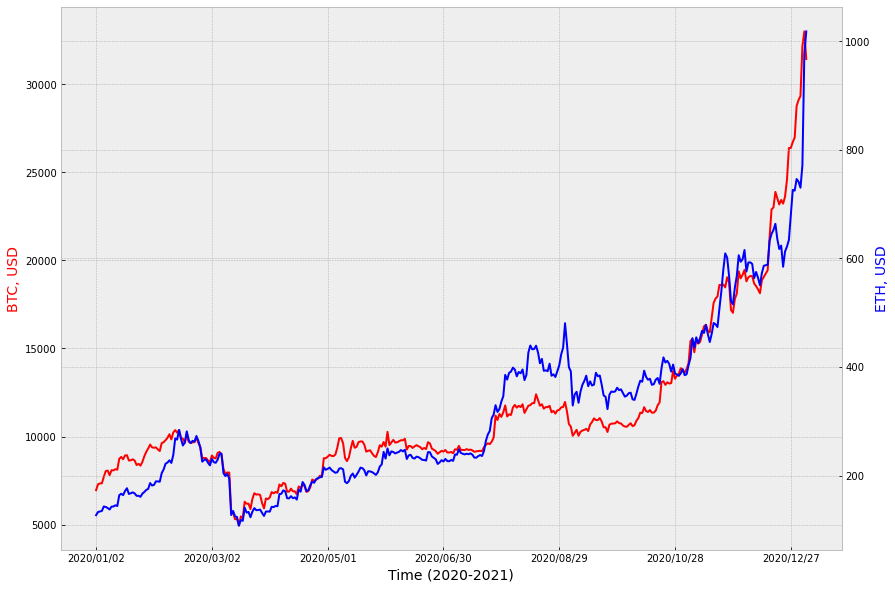

In [78]:
fig,ax = plt.subplots(figsize=(14, 10))
ax.plot(set_joint_dates['Date Time'], set_joint_dates['BTC Closing Price (USD)'], color="red")
ax.set_xlabel("Time (2020-2021)",fontsize=14)
ax.set_ylabel("BTC, USD",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(set_joint_dates['Date Time'], set_joint_dates['ETH Closing Price (USD)'], color="blue")
ax2.set_ylabel("ETH, USD",color="blue",fontsize=14)

myLocator = mticker.MultipleLocator(60)
ax.xaxis.set_major_locator(myLocator)
plt.show()

Note that Bitcoin prices correspond to the left axis, while Ethereum prices the right axis. For the year of 2020, there appear to be sycronized movement between these two cryptos' prices.

# 2 Data Exploration and Statistics

## 2.1 Are Bitcoin and Ethereum Cointegrated?

There seems to be a pretty strong correlation between these two crytocurrencies. I can perform the ADF test on the residuals of the regression of ETH on BTC to check if Bitcoin and Ethereum are Cointegrated. 

Mathematically, the residuals = BTC - `b`*ETH (`b` is the regression coefficient).

            BTC Opening Price (USD)  BTC Closing Price (USD)  \
Date Time                                                      
2020/01/02                      NaN                      NaN   
2020/01/03                -0.030559                 0.048269   
2020/01/04                 0.048269                 0.006366   
2020/01/05                 0.006366                 0.001335   
2020/01/06                 0.001335                 0.049871   
...                             ...                      ...   
2020/12/31                 0.066471                 0.011912   
2021/01/01                 0.011912                 0.007629   
2021/01/02                 0.007629                 0.096155   
2021/01/03                 0.096155                 0.026384   
2021/01/04                 0.026384                -0.047600   

            ETH Opening Price (USD)  ETH Closing Price (USD)  
Date Time                                                     
2020/01/02                      NaN      

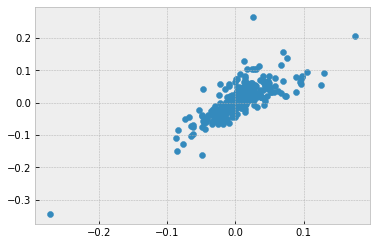

In [79]:
joint1 = set_joint_dates.set_index('Date Time')
returns = joint1.pct_change()
print(returns)
correlation = returns['BTC Closing Price (USD)'].corr(returns['ETH Closing Price (USD)'])
print("Correlation of Bitcoin and Ethereum returns: ", correlation)
plt.scatter(x=returns['BTC Closing Price (USD)'], y=returns['ETH Closing Price (USD)'])
plt.show()

Upon a quick glance, the returns of BTC and ETH are indeed correlated - with a correlation of 0.79. This means their returns tended to move together in 2020 - if you have bought both at the same time, more likely than no, when your ETHs are making positive returns, your BTCs are making similar degree of returns.  Are they also cointegrated?

Cointegration instead measures whether the difference between their means remains constant or not. To be cointegrated means these two variables can have a common trend that combines them in the long-run.

In [80]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

df = set_joint_dates.copy()
ETH, BTC = df.loc[:,'ETH Closing Price (USD)'], df.loc[:,'BTC Closing Price (USD)']

In [81]:
ETH = pd.DataFrame(ETH)
BTC = pd.DataFrame(BTC)

In [82]:
# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC['BTC Closing Price (USD)'] - b*ETH['ETH Closing Price (USD)'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.11439330716464446


The p-value is above 0.05, hence the 2020 pricing data doesn't suggest Bitcoin and Ethereum to be cointegrated.

## 2.2 Combine BTC Prices and the Three Pricing Drivers 

Now I join the BTC drivers with BTC prices into a single dataframe.

In [156]:
merged3 = pd.merge(left=merged2, right=set_joint_dates, left_on='Date Time', right_on='Date Time')
merged3 = merged3.drop(['BTC Opening Price (USD)','ETH Opening Price (USD)','ETH Closing Price (USD)'], axis=1)
merged3.tail(5)
merged3['Date Time'] = pd.to_datetime(merged3['Date Time'])
merged3 = merged3.set_index('Date Time')

In [157]:
merged3.describe()

,Total Number Bitcoin,Total Number of Confirmed Payments,Total Hash Rate (TH/s),BTC Closing Price (USD)
count,3.640000e+02,364.000000,3.640000e+02,364.000000
mean,1.839997e+07,578422.826923,1.194787e+08,11085.835297
std,1.251466e+05,80502.498194,1.578010e+07,4196.071254
min,1.813716e+07,390047.000000,7.570223e+07,4944.702336
25%,1.830102e+07,517825.250000,1.089694e+08,8900.411836
50%,1.842073e+07,578192.000000,1.187136e+08,9704.993166
75%,1.850466e+07,641682.750000,1.300063e+08,11666.261306
max,1.858572e+07,793177.000000,1.622631e+08,28768.836208


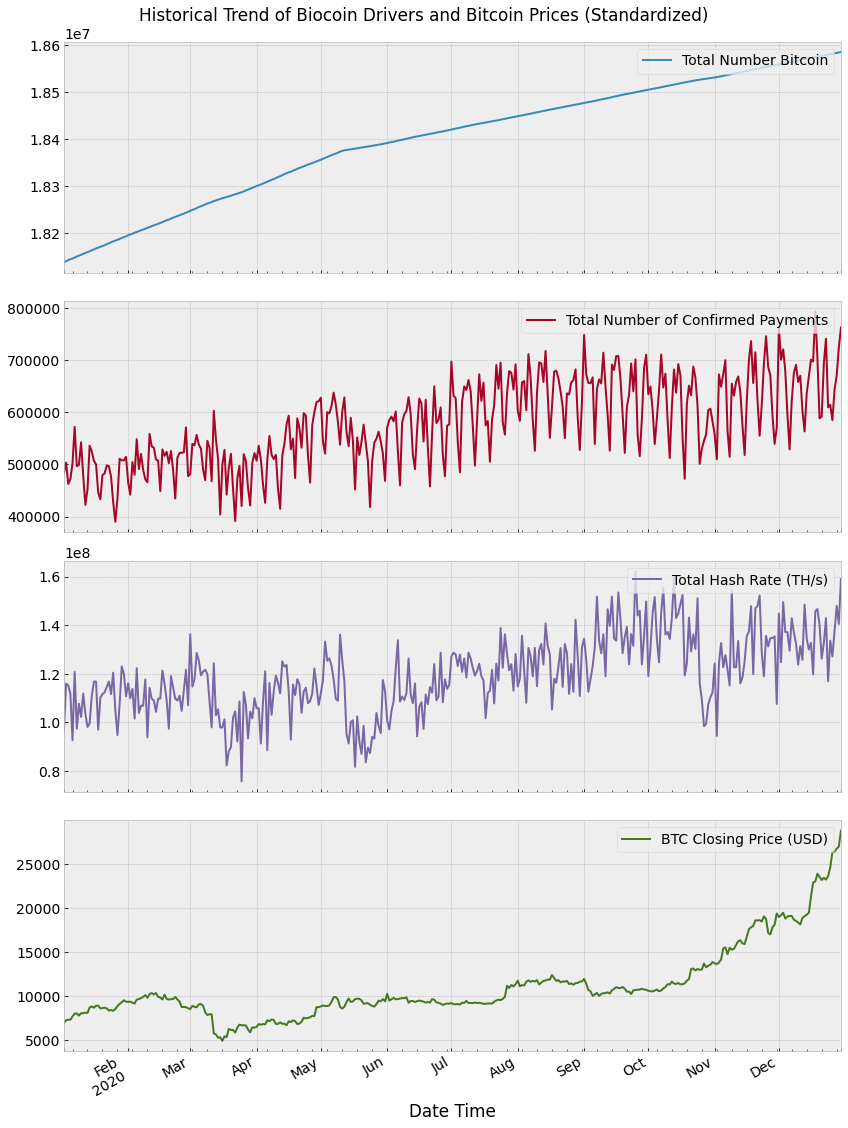

In [160]:
merged3[['Total Number Bitcoin', 'Total Number of Confirmed Payments', 'Total Hash Rate (TH/s)' , 'BTC Closing Price (USD)']].plot(subplots = True, figsize = (12,16))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.suptitle('Historical Trend of Biocoin Drivers and Bitcoin Prices (Standardized)')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

### 2.2.1 Normalization

To better understand the magnitude of the data, I will normalize the data using Standard Scaler.

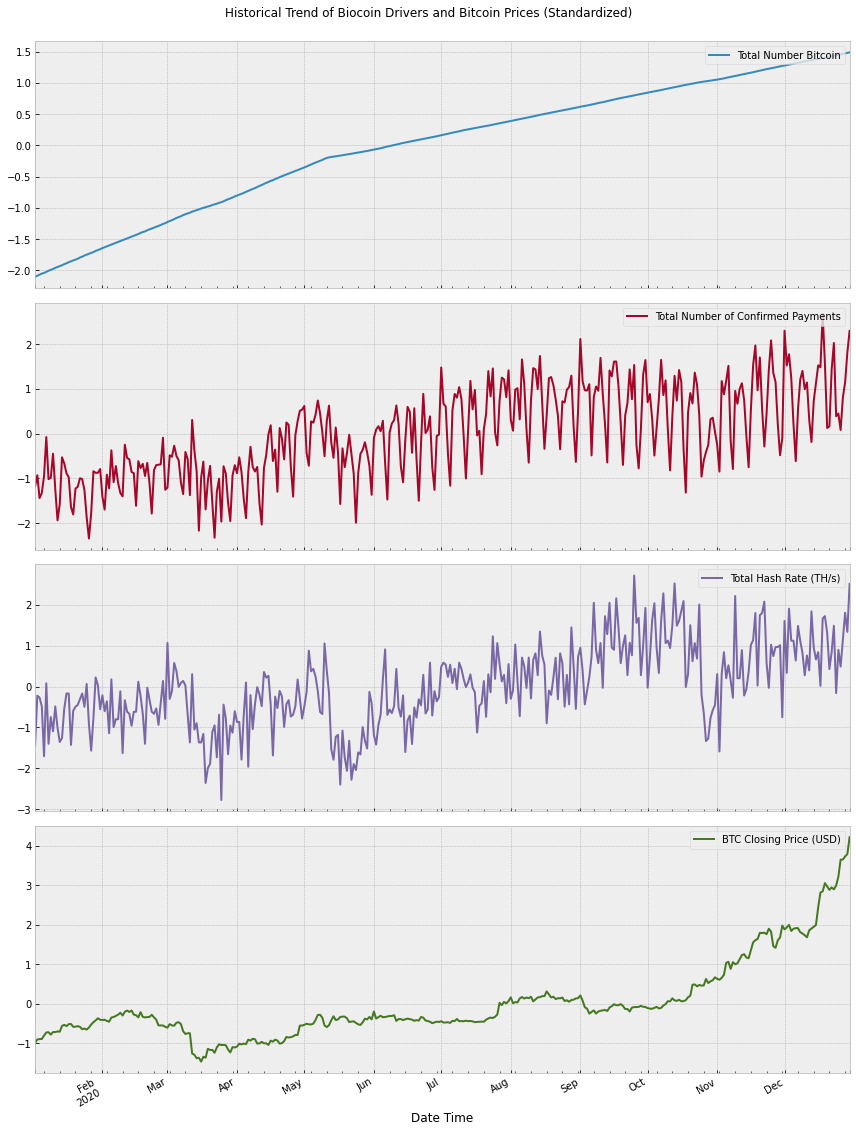

In [86]:
merged3copy = merged3.copy()

from sklearn.preprocessing import StandardScaler
x = ['Total Number Bitcoin','Total Number of Confirmed Payments', 'Total Hash Rate (TH/s)','BTC Closing Price (USD)']
scaler = StandardScaler()

for i in x:
    scaler.fit(merged3[[i]])
    merged3copy[i] = scaler.transform(merged3copy[[i]])
    
    
merged3copy['Date Time'] = pd.to_datetime(merged3copy['Date Time'])
merged3b = merged3copy.set_index('Date Time')

merged3b[['Total Number Bitcoin', 'Total Number of Confirmed Payments', 'Total Hash Rate (TH/s)' , 'BTC Closing Price (USD)']].plot(subplots = True, figsize = (12,16))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.suptitle('Historical Trend of Biocoin Drivers and Bitcoin Prices (Standardized)')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

### 2.2.2 Pairplot

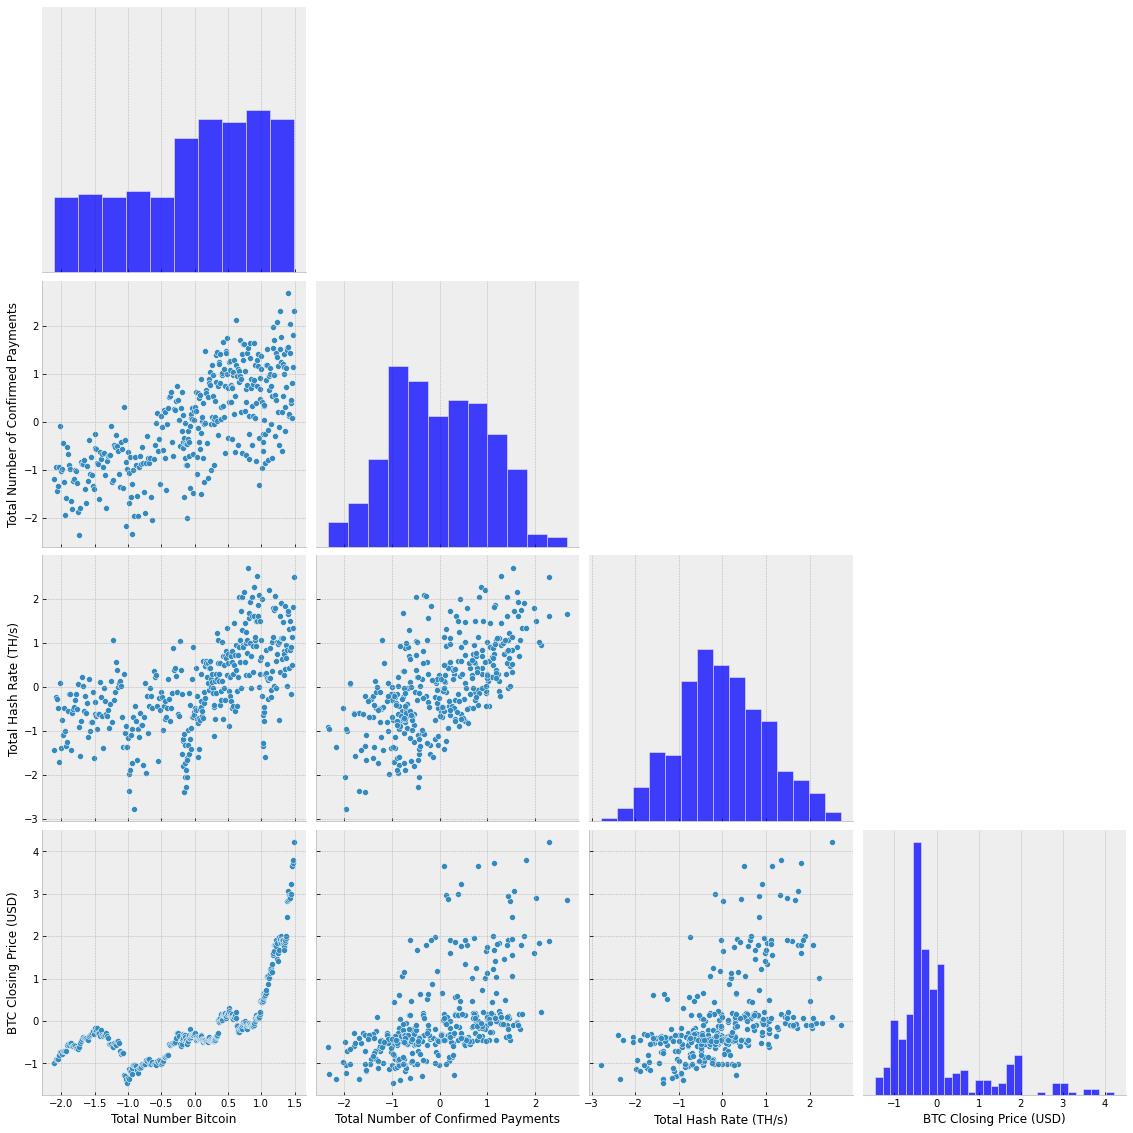

In [87]:
import seaborn as sns
sns.color_palette("cubehelix", as_cmap=True)
_ = sns.pairplot(merged3b,kind="scatter", height=4, corner=True)

There seems to be a pretty decent correlation between the number of bitcoin in circulation and bitcoin price, which is expected because as supply increase, the difficulty of mining increase, and the speed of bitcoin creation slows down. With a relative high market demand, the price of bitcoin went up.

### 2.2.3 Pearson Correlation Coefficient 
The linear correlations between BTC pricing and its individual drivers can be quantified using the **scipy.stats.pearsonr** function. The scipy.stats.pearsonr function returns the pearsonr coefficient and the two-tailed p-value. A signifance level of 5% is selected. 

If the p-value is lower than 5%, it is unlikely that an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

In [88]:
import scipy
scipy.stats.pearsonr(merged3b['BTC Closing Price (USD)'], merged3b['Total Number Bitcoin'])

(0.7048346302087315, 6.156374265184326e-56)

The coefficient is about 0.7, and the p-value is almost 0. I feel confident in saying that the BTC supply has significant impact on its pricing

Calculating the same pearson coefficient for the other two potential drivers. 

In [89]:
scipy.stats.pearsonr(merged3b['BTC Closing Price (USD)'], merged3b['Total Number of Confirmed Payments'])

(0.5415116938844331, 4.02382319888607e-29)

In [90]:
scipy.stats.pearsonr(merged3b['BTC Closing Price (USD)'], merged3b['Total Hash Rate (TH/s)'])

(0.5112737039660739, 1.2368657654509459e-25)

Similarly, the correlations between the pricing and both the demand (payments) and mining difficulty (hash rate) are positive. Given the extremely low p-value, such strong correlation is not a result of random chance.

### 2.2.4 Transform Data to Percent Change

I will define a new function called "percent_change" to calculate the percentage point change between the last values and the mean of previous values.

In [255]:
def percent_change(values):
        previous_values = values[:-1]
        last_value = values[-1]
        percent_change = (last_value - np.mean(previous_values))/np.mean(previous_values)
        return percent_change

Text(0.5, 1.0, '% Change Over Time')

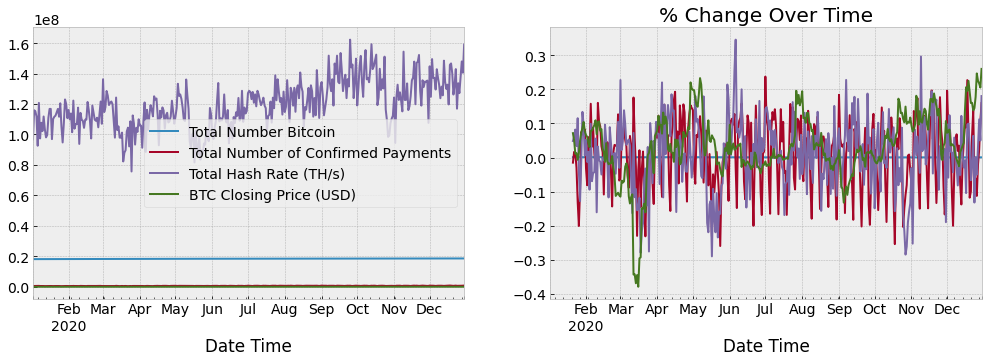

In [256]:
fig, axs = plt.subplots(1,2,figsize=(17,5))
ax = merged3.plot(ax=axs[0])
ax = merged3.rolling(window = 20).aggregate(percent_change).plot(ax=axs[1])
ax.legend_.set_visible(False)
plt.title("% Change Over Time")

These are budy figures - the one ont the left represent the raw data, in its original unit. Due to the fact that all the data has different scales, the result is we could really only see the trend of the total Hash Rate. On the right side, the percentage point changes for all four streams of data are graphed together. It can be a bit hard to tell them apart. 

I am going to separate them in their own subplot, and add some cutoff lines. This transformation helps me to detect outliers in the data. Outliers can have a negative effects on the predictive poewr of our ML models, biasing it away from its "true" value. One solution to remove the outliers to replace them with less extreme values.

##### Plotting a threshold on the data

In [253]:
merged3_perc_change = merged3.rolling(window = 20).aggregate(percent_change).dropna()

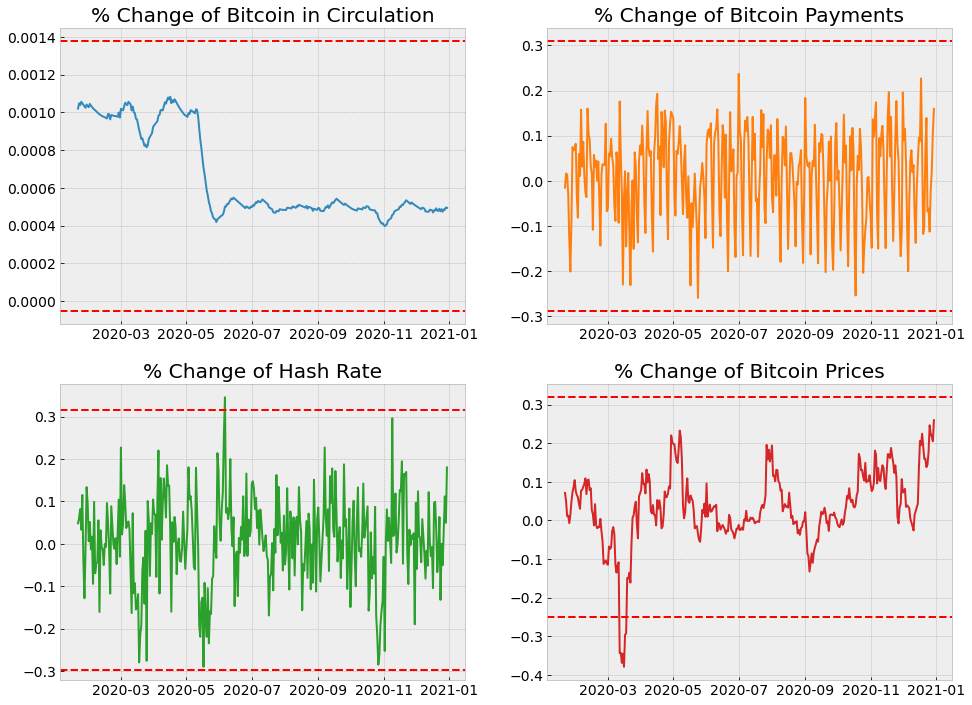

In [254]:
fig, axs = plt.subplots(2, 2,figsize=(16,12))
axs[0, 0].plot(merged3_perc_change.iloc[:,0])
axs[0, 0].set_title('% Change of Bitcoin in Circulation')
this_mean = merged3_perc_change.iloc[:,0].mean()
this_std = merged3_perc_change.iloc[:,0].std()
axs[0, 0].axhline(this_mean + this_std *3, ls='--',c='r')
axs[0, 0].axhline(this_mean - this_std*3, ls='--',c='r')

axs[0, 1].plot((merged3_perc_change.iloc[:,1]), 'tab:orange')
axs[0, 1].set_title('% Change of Bitcoin Payments')
this_mean = merged3_perc_change.iloc[:,1].mean()
this_std = merged3_perc_change.iloc[:,1].std()
axs[0, 1].axhline(this_mean + this_std *3, ls='--',c='r')
axs[0, 1].axhline(this_mean - this_std*3, ls='--',c='r')

axs[1, 0].plot((merged3_perc_change.iloc[:,2]), 'tab:green')
axs[1, 0].set_title('% Change of Hash Rate')
this_mean = merged3_perc_change.iloc[:,2].mean()
this_std = merged3_perc_change.iloc[:,2].std()
axs[1, 0].axhline(this_mean + this_std *3, ls='--',c='r')
axs[1, 0].axhline(this_mean - this_std*3, ls='--',c='r')

axs[1, 1].plot((merged3_perc_change.iloc[:,3]), 'tab:red')
axs[1, 1].set_title('% Change of Bitcoin Prices')
this_mean = merged3_perc_change.iloc[:,3].mean()
this_std = merged3_perc_change.iloc[:,3].std()
axs[1, 1].axhline(this_mean + this_std *3, ls='--',c='r')
axs[1, 1].axhline(this_mean - this_std*3, ls='--',c='r')

The red dotted lines indicate the cutoff for outliers of each feature of our merged3 dataset. It doesn't look like our datasert is polluted with many outliers. I chose to not replace any outliers because of the scarcity of such events. 

Out of curiosity, I am going to also graph the standardized dataset. I am expecting much less volatility in the % Change Over Time figure.

Text(0.5, 1.0, '% Change Over Time')

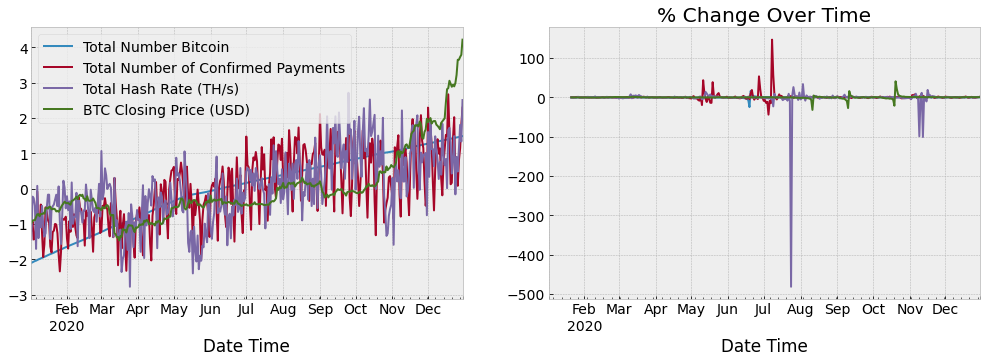

In [258]:
fig, axs = plt.subplots(1,2,figsize=(17,5))
ax = merged3b.plot(ax=axs[0])
ax = merged3b.rolling(window = 20).aggregate(percent_change).plot(ax=axs[1])
ax.legend_.set_visible(False)
plt.title("% Change Over Time")

As expected, the figure on the right was significantly tamed. This is because the data represented are the number of standard deviations that the raw data deviates from the mean - so the percentage change doesn't make a lot of sense. For instance, the huge drop of Hash Rate in August appears to be so steep only because the standard deviation was floating around 0 - causing an "inappropriate" degree of change when there are unusual events happening to the raw total Hash Rate.

# 3 Machine Learning

The goal is is to find the most reasonable ML model, fit it onto the BTC pricing data (time series) and use that to predict the future prices. Here, the dependent variable is BTC Closing Price in USD, and the independent variables include the number of payments, number of bitcoin in the market and total hash rate.

Besides, time series data tends to be correlated temporaly ( or serially dependent). This is also called as auto-correlation and forms an important aspect of the conventional time series modeling techniques like (S)ARIMA(X).

Now it's time to rename the dataframe and the columns -

In [91]:
data = merged3.copy()
data = data.rename(columns={"BTC Closing Price (USD)": "BTC", "Total Hash Rate (TH/s)": "HR", 'Total Number of Confirmed Payments':'payments', 'Total Number Bitcoin':'circulation'})

In [92]:
dict_error = dict()

In [93]:
# creating function for plotting predicted vs actual energy values
def plot_predvstrue_reg(pred, truth, model_name=None):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Historical BTC Prices in USD")
    _ = plt.ylabel("Predicted BTC Prices in USD")
    _ = plt.title("Historical vs Predicted BTC Prices Model {}".format(model_name))

    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)

In [94]:
def error_metrics(y_pred, y_truth, model_name = None, test = True):

    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            dict_error[error[0]].append(error[1])
        else:
            dict_error[error[0]] = [error[1]]
    #return(dict_error)

In [95]:
def plot_timeseries(ts, title = 'og', opacity = 1):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = ts.index, y = ts.values, name = "observed",
                         line_color = 'lightslategrey', opacity = opacity))
    fig.update_layout(title_text = title,
                  xaxis_rangeslider_visible = True)
    fig.show()

In [96]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))

    fig.update_layout(title_text = 'Observed Test Set vs Predicted BTC Prices Using {}'.format(model_name),
                  xaxis_rangeslider_visible = False)
    fig.show()

In [119]:
def train_test(data0,scale = True, test_size = 0.3, cols_to_transform=['circulation','payments','HR'], include_test_scale=True):
    df = data0.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
            scaler = StandardScaler()
            df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop(['BTC','date'], axis = 1).iloc[:test_index]
    y_train = df.BTC.iloc[:test_index]
    X_test = df.drop(['BTC','date'], axis = 1).iloc[test_index:]
    y_test = df.BTC.iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

In [98]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 3.1 Statsmodel Simple Linear Regression

Frist - I would like to explore the relationship between the BTC prices and a simple linear regression. 

In [99]:
from pandas import Series

data['date'] = pd.to_datetime(data['Date Time'])
data['date'] = data['date'].astype(int)

In [100]:
data = data.drop('Date Time', axis=1)

##### Fitting linear regression using statsmodel

In [101]:
X = data[['circulation', 'HR','payments']] 
y = data['BTC']
m = sm.OLS(y,X).fit()
print(m.summary())

                                 OLS Regression Results                                
Dep. Variable:                    BTC   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              1326.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):                   1.66e-194
Time:                        13:17:49   Log-Likelihood:                         -3478.3
No. Observations:                 364   AIC:                                      6963.
Df Residuals:                     361   BIC:                                      6974.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

Plotting the observed vs predicted values for the above statsmodel linear regression model

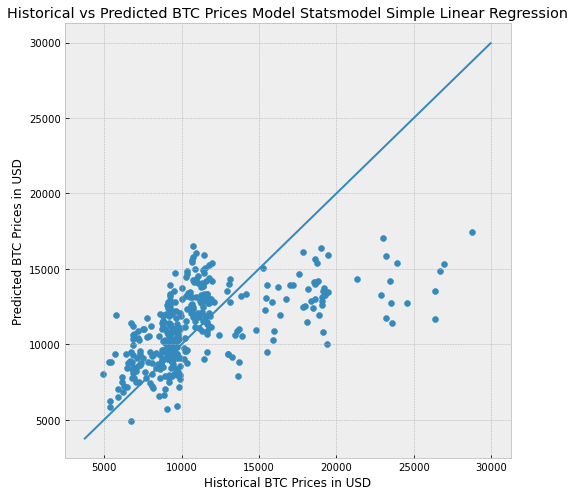

In [102]:
plot_predvstrue_reg(m.fittedvalues, data.BTC, model_name = 'Statsmodel Simple Linear Regression')

The R2 and adjusted R2 for a simple model like OLS are very good (~0.92), indicating that these three drivers are very much correlated to BTC pricing.

However, the coefficients are very low, which could be attributed to two reasons -
(1) the data range are magnitudes away
(2) these drivers might not be great explainatory factors for BTC pricing

It is also worth noting that the dataset is not split into train and test sets. 

## 3.2 Sklearn Linear Regression Model

In [108]:
lm = LinearRegression()
X_train, X_test, y_train, y_test = train_test(data)

In [109]:
lm.fit(X_train, y_train)

LinearRegression()

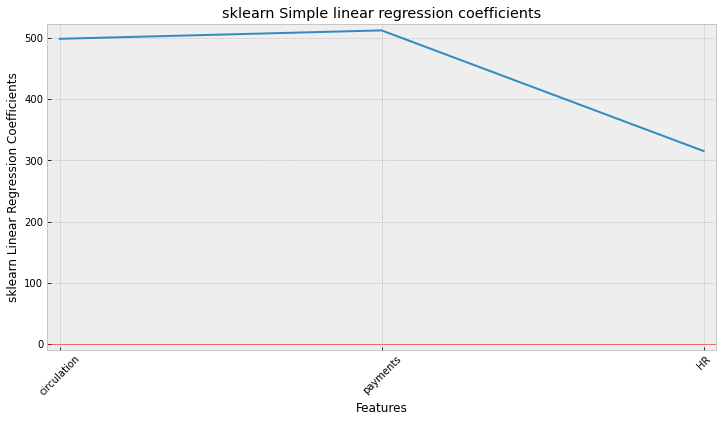

In [110]:
# Plotting the coefficients to check the importance of each coefficient 

_ = plt.figure(figsize = (12, 6))
_ = plt.plot(range(len(X_train.columns)), lm.coef_)
_ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 45)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('sklearn Simple linear regression coefficients')
_ = plt.ylabel('sklearn Linear Regression Coefficients')
_ = plt.xlabel('Features')

So all three drivers contribute to the BTC prices positively.

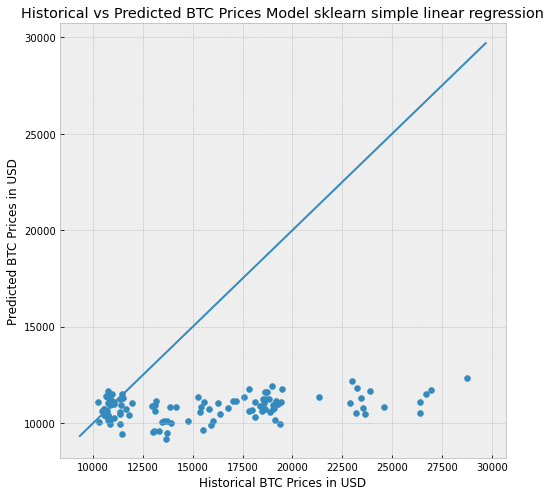

In [112]:
plot_predvstrue_reg(lm.predict(X_test), y_test, model_name = 'sklearn simple linear regression')

Uh oh - these are not great predictions. I've tried to tune the hyperparameters but it is not improving. Maybe predicting Bitcoin prices using three drivers is a too simplistic approach. Maybe using one year's data is not a large enough sample pool.

## 3.3 Sklearn Random Forest Regression

Although the results of Sklearn linear regression is disappointing, I will try Sklearn Random Forest Regression

In [120]:
n_estimators = [int(x) for x in np.linspace(10, 800, 20, endpoint=True)]
max_features = ['auto', 'sqrt']
max_depth = list(range(2,10))

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}

In [121]:
X_train, X_test, y_train, y_test = train_test(data)

In [122]:
#import randomsearchcv
from sklearn.model_selection import RandomizedSearchCV

# First create the base model to tune
rf = RandomForestRegressor()

# Creating a time series split as discussed in the Introduction
#tscv = TimeSeriesSplit(n_splits=2)

# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = 10, random_state = 9, n_jobs = -1)

rf_random.fit(X_train, y_train)
rf_random.best_params_

{'n_estimators': 259, 'max_features': 'auto', 'max_depth': 6}

In [123]:
rf_random.score(X_train, y_train)

0.9889172866936033

In [124]:
rf_random.score(X_test, y_test)

-1.295588640544402

This test score of -1.3 is disappointing, but not surprising - the limitation of using just one year's data and only three drivers is shown.

In [126]:
# Plotting the predicted values with the original time series (test set)
plot_ts_pred(y_test, rf_random.predict(X_test), model_name='Random Forest Regression', 
             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

The above is a visualization of our (poor) prediction of the high prices in mid- to late-2020.

In [127]:
# Random forest error metrics
print('Tuned Random forest errors on training set')
error_metrics(rf_random.predict(X_train), y_train, model_name = 'Tuned Random forest with reduced hour space', test = False)
print('\nTuned Random forest errors on test set')
error_metrics(rf_random.predict(X_test), y_test, model_name = 'Tuned Random forest with reduced hour space', test = True)

Tuned Random forest errors on training set

Error metrics for model Tuned Random forest with reduced hour space
RMSE or Root mean squared error: 164.35
Variance score: 0.99
Mean Absolute Error: 123.14
Mean Absolute Percentage Error: 1.40 %

Tuned Random forest errors on test set

Error metrics for model Tuned Random forest with reduced hour space
RMSE or Root mean squared error: 7155.32
Variance score: -1.30
Mean Absolute Error: 5367.70
Mean Absolute Percentage Error: 28.52 %


Perhaps not too surpringly, Random Forest Regression is also a very poor model for our BTC data. 

## 3.4 Autocorrelation

Autocorrelation is the correaltion of a single time series with a lagged copy of itself, also known "serial correlation". In our case, when BTC returns have a negative correlation, we can say it is "mean reverting"; and if BTC returns have a positive correaltion, it is "trend following".

In the world of investment, individual stocks tend to have a negative autocorrelation over intervals of a week, and commodities/currencies tend to have positive autocorrelation historically. 

In [128]:
merged3['Date Time'] = pd.to_datetime(merged3['Date Time'])
BTC = merged3[['Date Time','BTC Closing Price (USD)']].set_index('Date Time')
BTC = BTC.resample(rule = 'W').last()

# Compute the percentage change of prices
returns = BTC.pct_change()

In [129]:
autocorrelation = returns['BTC Closing Price (USD)'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is 0.08


Notice how the autocorrelation of returns for BTC is positive, so the prices are "trend following", which seems to be true given that prices in 2020 had gone mostly up nonstop.

ACF can help to visualize the optimal lag(s) when the past can inform the future data. In the below function, alpha is our confidence interval. A 0.05 alpha value means a 95% CI.

The approximate confidence interval is +/- 0.27
[ 1.          0.84228031  0.70136201  0.57590381  0.51260284  0.43625094
  0.37358484  0.29105706  0.24512578  0.19064789  0.16003107  0.12215664
  0.10855592  0.09101493  0.08093597  0.06495323  0.04608617  0.036154
  0.03279715  0.0078761  -0.01452683 -0.04546361 -0.07617111 -0.098426
 -0.10800357 -0.10778199 -0.11699774 -0.12415797 -0.13557863 -0.1512443
 -0.17297138 -0.19490834 -0.21508548 -0.22711863 -0.2551206  -0.26776666
 -0.29093766 -0.28986087 -0.28596364 -0.27918268 -0.27537902]


/Users/yh/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



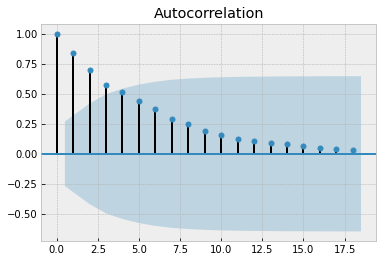

In [130]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

nobs = len(returns)
conf = 1.96/np.sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

acf_array = acf(BTC)
print(acf_array)

# Plot the acf function
plot_acf(BTC, alpha=0.05)
plt.show()

Clearly, lags 1, 2 and 3 are significantly positive and that means the prices 1-3 days prior could inform the price on the day of interest.

## 3.5 Random Walk   

The Augmented Dicky-Fuller test will tell us whether we can reject the null hypothesis that the series is a random walk with a certain degree on confidence (conventionally, we use 95%).

In [131]:
from statsmodels.tsa.stattools import adfuller

BTC = merged3[['Date Time','BTC Closing Price (USD)']].set_index('Date Time')
results = adfuller(BTC['BTC Closing Price (USD)'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(4.13123935386048, 1.0, 0, 363, {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}, 5097.872723364499)
The p-value of the test on prices is: 1.0


According to this test, we cannot reject the hypothesis that BTC prices follow a random walk. But now I will look at BTC returns.

In [132]:
# Create a DataFrame of BTC returns
BTC_ret = BTC.pct_change()
BTC_ret = BTC_ret.dropna()

# Run the ADF test on the return series and print out the p-value
results = adfuller(BTC_ret)
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 7.094904957082776e-14


The p-value is through the roof - we can't reject the hypothesis that returns are a random walk. This is empirically true - the surge in BTC prices in late 2020 was certainly a huge shock to most. 

## 3.6 Stationarity

A time series data's stationarity is important because it shows us whether the distribution of datais tim-variant or not. A strong stationarily translates to time-variant data, and a weak stationarity implies that the mean, variance and autocorrelation are time-invariant. 

If a series isn't stationary, it might become difficult to model. But a simple transformation can make a non-stationary dataset stationary. I believe there is no apparent seasonality in BTC prices, but I will do a log transformation on BTC prices to see if there is anything to uncover -

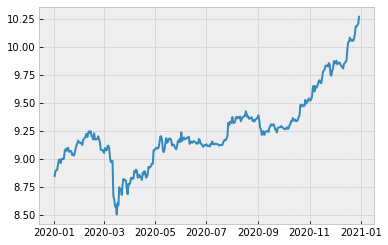

In [133]:
plt.plot(np.log(BTC))

Judging by the above figure, the BTC prices do not seem to be stationary data.

## Fourier Transformation



## 3.7 SRIMAX Model

In [134]:
from scipy.stats import norm
from io import BytesIO
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [135]:
merged3.index.freq="QS-OCT"

# Fit the model
mod = sm.tsa.statespace.SARIMAX(merged3['BTC Closing Price (USD)'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

                                  SARIMAX Results                                  
Dep. Variable:     BTC Closing Price (USD)   No. Observations:                  364
Model:                    SARIMAX(1, 1, 1)   Log Likelihood               -2670.964
Date:                     Sat, 03 Apr 2021   AIC                           5349.929
Time:                             13:27:02   BIC                           5365.506
Sample:                                  0   HQIC                          5356.121
                                     - 364                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5183      2.731      0.556      0.578      -3.835       6.871
ar.L1          0.9805      0.036     27.538      0.000       0.911       1.050
ma.L1       